In [1]:
import pymc3 as pm
import theano
from theano import tensor as T
import sklearn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X, Y = datasets.make_blobs(n_samples=200, n_features=2, centers=2, cluster_std=3.0,
                           center_box=(-5.0, 5.0), shuffle=True, random_state=None)

X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

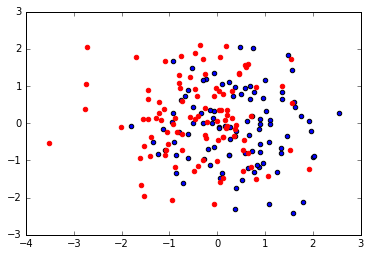

In [3]:
plt.scatter(X[Y==0, 0], X[Y==0, 1])
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r')

In [4]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

 [-----------------100%-----------------] 50000 of 50000 complete in 16.8 sec

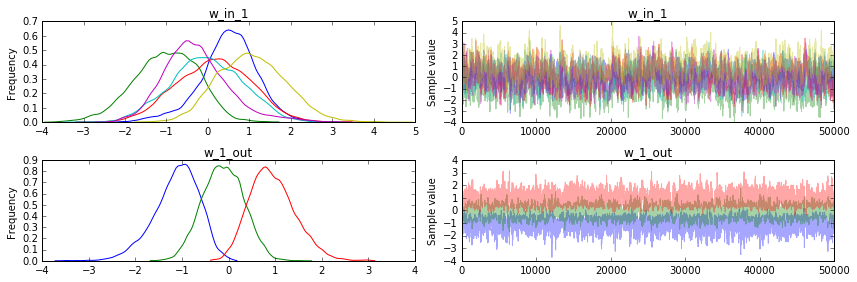

In [5]:
with pm.Model() as model:
    # Below we require an ordering of the summed weights, thus initialize in this order
    init_1 = np.random.randn(X.shape[1], 3)
    init_1 = init_1[:, np.argsort(init_1.sum(axis=0))]
    init_2 = np.random.randn(3)
    init_2 = init_2[np.argsort(init_2)]
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(X.shape[1], 3), 
                             testval=init_1)
    # Weights from hidden layer to output
    weights_1_out = pm.Normal('w_1_out', 0, sd=1, shape=(3,), 
                              testval=init_2)

    # As the hidden neurons are interchangeable this induces a symmetry in the posterior.
    # This is my first attempt at breaking that symmetry. I'm not sure if it's actually
    # correct or if there is a better way to do it. It seems to work for this toy model.
    pm.Potential(
        'order_means_potential',
        T.switch(T.ge(T.sum(weights_in_1[:, 0]), T.sum(weights_in_1[:, 1])), -np.inf, 0)
        + T.switch(T.ge(T.sum(weights_in_1[:, 1]), T.sum(weights_in_1[:, 2])), -np.inf, 0))

    # Not sure if this is required...
    pm.Potential(
        'order_means_potential2',
        T.switch(T.ge(weights_1_out[0], weights_1_out[1]), -np.inf, 0)
        + T.switch(T.ge(weights_1_out[1], weights_1_out[2]), -np.inf, 0))
    
    # Do forward pass
    a1 = T.dot(ann_input, weights_in_1)
    act_1 = T.nnet.sigmoid(a1)
    act_out = T.dot(act_1, weights_1_out)
    
    out = pm.Bernoulli('out', 
                       T.nnet.sigmoid(act_out),
                       observed=ann_output)
    
    step = pm.Metropolis()
    trace = pm.sample(50000, step=step)

pm.traceplot(trace);

In [6]:
# Replace shared variables with testing set
# (note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=model, samples=500)
pred = ppc['out'].mean(axis=0) > 0.5

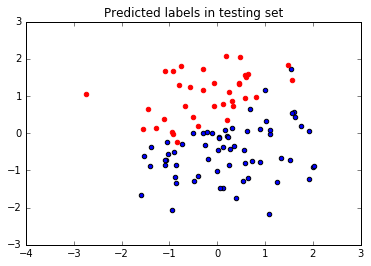

In [7]:
plt.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
plt.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
plt.title('Predicted labels in testing set')

In [8]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 59.0%


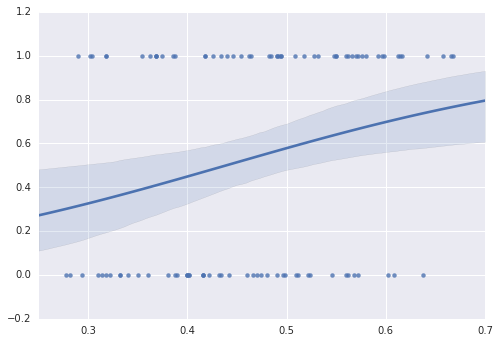

In [9]:
# pip install statsmodels
import seaborn as sns
sns.regplot(ppc['out'].mean(axis=0), Y_test, logistic=True)

In [10]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [11]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)
# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=model, samples=500)
pred = ppc['out'].mean(axis=0)


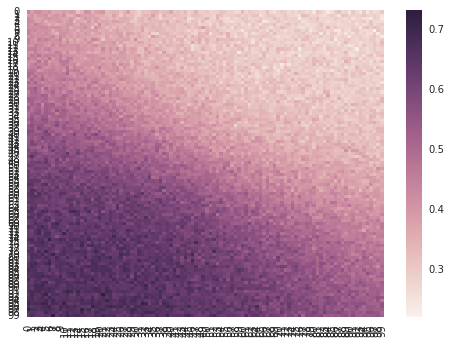

In [12]:
sns.heatmap(pred.reshape(100, 100).T)

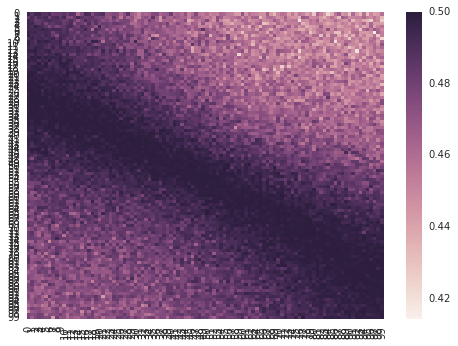

In [13]:
sns.heatmap(ppc['out'].std(axis=0).reshape(100, 100).T)